# Predicting Boston Housing Prices Introduction

Project developed for Udacity's Machine learning nano degree. For more information check out their [website](www.udacity.com).

For an HTML rendering, please visit the [github.io](https://t-lanigan.github.io/boston-housing-price-prediction/).

In this project, we will apply basic machine learning concepts on data collected for housing prices in the Boston, Massachusetts area to predict the selling price of a new home. We will first explore the data to obtain important features and descriptive statistics about the dataset. Next, the data will be split into testing and training subsets and a suitable performance metric is determined for this problem. I will then analyze performance graphs for a learning algorithm with varying parameters and training set sizes. This will enable us to pick the optimal model that best generalizes for unseen data. Finally, we will test this optimal model on a new sample and compare the predicted selling price to the statistics.

A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

# Getting Started

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are hypothesized to be essential for this analysis. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation. 

Complete Attribute information is shown below:
* `CRIM`: per capita crime rate by town
* `ZN`: proportion of residential land zoned for lots over 25,000 sq.ft.
* `INDUS`: proportion of non-retail business acres per town
* `CHAS`: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* `NOX`: nitric oxides concentration (parts per 10 million)
* `RM`: average number of rooms per dwelling
* `AGE`: proportion of owner-occupied units built prior to 1940
* `DIS`: weighted distances to five Boston employment centers
* `RAD`: index of accessibility to radial highways
* `TAX`: full-value property-tax rate per 10,000
* `PTRATIO`: pupil-teacher ratio by town
* `B`: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* `LSTAT`: percentage lower status of the population
* `MEDV`: Median value of owner-occupied homes in $1000's

In [62]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import visuals as vs # Supplementary code
from sklearn.cross_validation import ShuffleSplit
import matplotlib as plt
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydot
import sys
sys.path.append("/usr/local/lib/python2.7/site-packages")

# Display settings.
%matplotlib inline
plt.style.use('ggplot')

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

# Set a random state for the training algorithms
RAN_STATE = 29
#Set size for figures
FIG_SIZE = (14,8)

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

In [36]:
print prices.head()
print features.head()

0    504000
1    453600
2    728700
3    701400
4    760200
Name: MEDV, dtype: float64
      RM  LSTAT  PTRATIO
0  6.575   4.98     15.3
1  6.421   9.14     17.8
2  7.185   4.03     17.8
3  6.998   2.94     18.7
4  7.147   5.33     18.7


## Calculate Basic Statistics

A calculation of basic statistic on the dataset for use in analysis later.

In [37]:
minimum_price = np.min(prices)
maximum_price = np.max(prices)
mean_price = np.mean(prices)
median_price = np.median(prices)
std_price = np.std(prices)
def show_data_stats():# Show the calculated statistics
    print "\nStatistics for Boston housing dataset:\n"
    print "Minimum price: ${:,.2f}".format(minimum_price)
    print data.iloc[[data['MEDV'].argmin()]]
    print "\nMaximum price: ${:,.2f}".format(maximum_price)
    print data.iloc[[data['MEDV'].argmax()]]
    print "\nPrice Range: ${:,.2f}".format(maximum_price-minimum_price)
    print "Mean price: ${:,.2f}".format(mean_price)
    print "Median price ${:,.2f}".format(median_price)
    print "Standard deviation of prices: ${:,.2f}".format(std_price)
    
show_data_stats()


Statistics for Boston housing dataset:

Minimum price: $105,000.00
        RM  LSTAT  PTRATIO    MEDV
381  5.453  30.59     20.2  105000

Maximum price: $1,024,800.00
        RM  LSTAT  PTRATIO     MEDV
253  8.398   5.91       13  1024800

Price Range: $919,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


## Feature Observation

In order to gain an intuition of the effect of each feature on the `MERV` value, each are visualized.

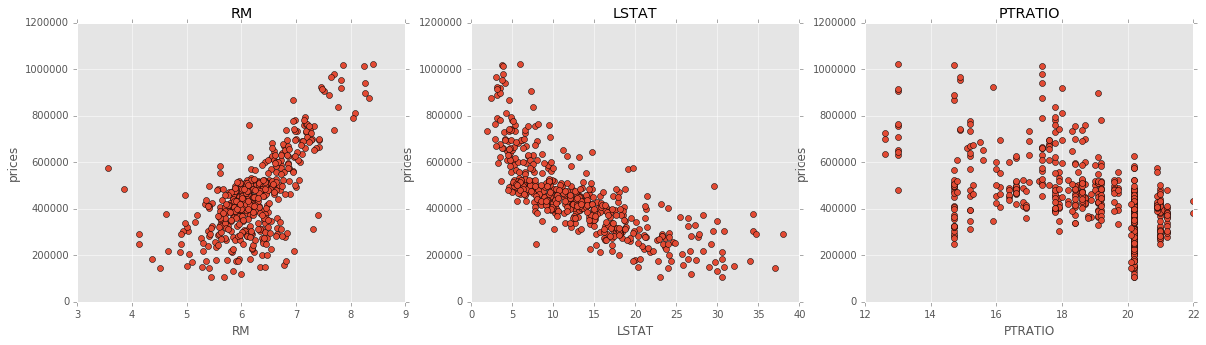

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, (i+1))
    plt.plot(data[col], prices, 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')

## Data feature analysis

As can be seen from the graphs above:
* As the `'RM'` value increases, the `'MEDV'` should increase as each of the houses in that neighbourhood has more rooms, and is thus more desirable (i.e a `RM` value of 6 should be worth less than a `RM` values of 7).
* As the `'LSTAT'` value increases, the `'MEDV'` should be expected to decrease, as having more lower class people in a neighbourhood is considered undesirable.
* As the `'PTRATIO'` increases, the `'MEDV'` should be expected to decrease as having more students in neighbourhood schools is typically considered undesirable. The effect of this is more slight than then other two variables.

----

# Developing a Model

In this second section of the project, we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in the predictions.

## Implementation: Define a Performance Metric

It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will use the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify the model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 always fails to predict the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. *A model can be given a negative R<sup>2</sup> as well, which indicates that the model is no better than one that naively predicts the mean of the target variable.*

In [39]:
from sklearn.metrics import r2_score
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    score = r2_score(y_true,y_predict)    
    # Return the score
    return score

## Shuffle and Split Data

Now we will shuffle and split the data into 80% training and 20% testing.

In [40]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,prices, test_size=0.2, random_state=42)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


The benefit to splitting the data into testing and training sets is that this allows simulated evaluation of how well the model is performing before using it in the real world to make predictions. 

If there was no testing set, there would be no way of realistically evaluating the model as you would only be able to measure it's performace on data to which it's already been exposed. This will result in a false sense of confidence in how well the model performs.

----

# Analyzing Model Performance

In the third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, we'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing the model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

## Learning Curves

The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  


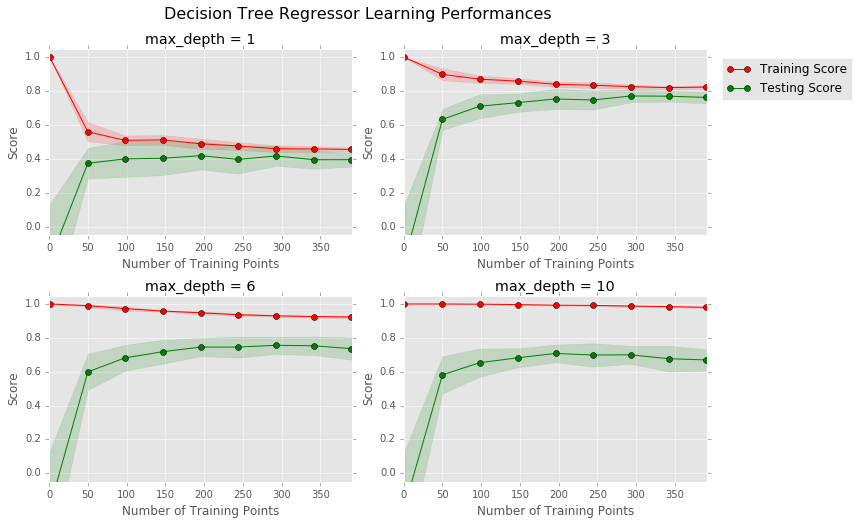

In [41]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

In the max_depth = 3 graph, the training and testing scores seems to converge at a high score level. This is indicative of a well designed model, as it doesn't have high error between the training and validation score (indicating high varience and a model that is too complex and overfits the data) or a low convergence score (indicating high bias due to a model that is not complex enough and underfits the data). As the values seems to converge at roughly 250 points of data, it does not appear that adding any more data points would cuase the model to perform better.

## Complexity Curves

The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

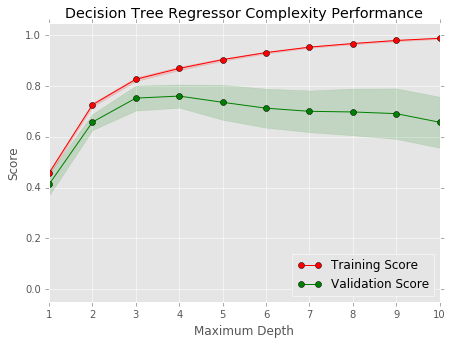

In [61]:
vs.ModelComplexity(X_train, y_train)

## Bias-Variance Tradeoff

At a depth of 1, the model suffers from high bias, it is simply not complicated enough to describe the underlying data. This is evidenced by the validation and training scores being low at low model complexities. When it is trained to a maximum depth of 10, it suffers from high variance. It is too compicated and overfits the data. This is evidenced by the error between the testing score and the validation score. It is noted that the validation score decreases as the maximum depth is increased past 3-4.

## Best-Guess Optimal Model

Based on the complexity curves shown above, it would seem that the best maximum depth for the decision tree regressor is 3 or 4.

-----

# Evaluating Model Performance

In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`. In order to optimize the model, we will use two techniques: Grid Search for parameter optimization, and k-folds cross validation. These techniques have been briefly discussed below.

## Grid Search

The grid search technique works by generating a grid of all possible provided parameter combinations. It then evaluates a model using a validation set based on every combination of parameters in the grid. It is used to find the optimum set of parameters for a learning algorithm given a data set.

## Cross-Validation

The k-folds validation training technique creates multiple testing and training sets and trains a model on each, averaging the results. The splitting method is to divide the data into separate bins (for example k = 5),  train on bins 1 to k-1 and test on bin k. The next fold trains on bins 2 to k and tests on bin 1 and so on, until all of the bins have acted as a test bin. This effectively trains and tests the models on all of the data without over-fitting to the data.

The benefits that this provides for grid search while optimizing the model is that there is less of a chance that the final model won't be optimized to data that could potentially have a bias. For example, if somehow, all of the training data didn't contain a unique data point (such as a high `MEDV` value for a low `RM`) the final model would be very biased not predict this scenario, and the optimization will make that worse. However, with k-folds validation, one of the trained models will see the unique data point and the result will be reflected in the final averaged model. 

## Implementation: Fitting a Model

The following is a function definition to perform a grid search on a decision tree model and return the optimum model.

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn import grid_search


def fit_model(X, y):
    """ Performs grid search over the 'max_depth' and 'min_sample_split' parameters 
        for a decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    
    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state=RAN_STATE)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': list(range(1,11)),
              'min_samples_split': list(range(1,5))}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric) 

    # Create the grid search object
    grid = grid_search.GridSearchCV(regressor, params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    
    # Return the optimal model after fitting the data
    return grid.best_estimator_




## Optimal Model

The optimum model in terms of bias and variance trade-off for our dataset can now be determined.

In [44]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])
print "Parameter 'min_samples_split' is {} for the optimal model.".format(reg.get_params()['min_samples_split'])

Parameter 'max_depth' is 4 for the optimal model.
Parameter 'min_samples_split' is 4 for the optimal model.


The result of a max_depth of 4 for the model is the same as what was observed in the model complexity visualization.

## Predicting Selling Prices

Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |


We will now attempt to use our intuition to make predictions for each client's home.

A couple helpful statistics:

In [54]:
show_data_stats()
print 'The max and min RM values in the set:', data['RM'].max(), data['RM'].min() 
print 'The max and min LSTAT values in the set:', data['LSTAT'].max(), data['LSTAT'].min() 
print 'The max and min PTRATIO values in the set:', data['PTRATIO'].max(), data['PTRATIO'].min() 


Statistics for Boston housing dataset:

Minimum price: $105,000.00
        RM  LSTAT  PTRATIO    MEDV
381  5.453  30.59     20.2  105000

Maximum price: $1,024,800.00
        RM  LSTAT  PTRATIO     MEDV
253  8.398   5.91       13  1024800

Price Range: $919,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13
The max and min RM values in the set: 8.398 3.561
The max and min LSTAT values in the set: 37.97 1.98
The max and min PTRATIO values in the set: 22.0 12.6


We can also plot a histogram of all of the housing prices in this dataset and see where each of these predictions fall. The vertical lines signify where each of the new clients would be located.

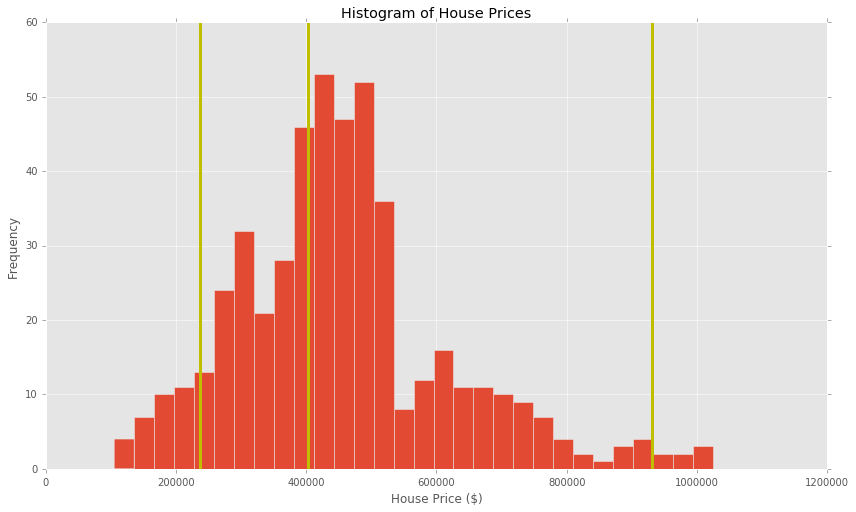

In [55]:
plt.figure(figsize= FIG_SIZE)
plt.hist(prices, bins = 30)
for price in reg.predict(client_data):
    plt.axvline(price, c = 'y', lw = 3)

plt.title("Histogram of House Prices")
plt.ylabel('Frequency')
plt.xlabel('House Price ($)')
plt.show()

Looking at the statistics above we can make a rough estimate for each of the clients expected house value. According the the hypothesis made in the beginning of the notebook:

- As `'RM'` value increases, the `'MEDV'` should increase.
- As `'LSTAT'` value increases, the `'MEDV'` should be expected to decrease.
- As `'PTRATIO'` increases, the `'MEDV'` should be expected to decrease.

### For client 1:

* An `RM` value of 5 is on the lower side in terms of the other data as so would suggest a `MEDV` value lower than the mean of the rest of the data.
* An `LSTAT` of 17% is around the center of the max and min values seen for the data and would suggest a `MEDV` value around the mean of the data. 
* An `PTRATIO` of 15 to 1 is in the lower half of the rest of the data and would suggest a higher than average `MERV`
* The overall expectation is a `MERV` value within a standard deviation of the mean as all of it's categories are middle of the road with respect to the rest of the data.

### For client 2:

* An `RM` value of 4 is on the lower side in terms of the other data as so would suggest a `MEDV` value lower than the mean of the rest of the data.
* An `LSTAT` of 32% is on the higher side in terms of the data and so would again suggest a `MEDV` value lower than the mean of the rest of the data 
* An `PTRATIO` of 22 to 1 is in the higher half of the rest of the data and so would again suggest a `MEDV` value lower than the mean of the rest of the data 
* The overall expectation is that the `MERV` value should be below a standard deviation of the mean as it scores on the lower side on all categories.

### For client 3:

* An `RM` value of 8 is on the higher side in terms of the other data as so would suggest a `MEDV` value higher than the mean of the rest of the data.
* An `LSTAT` of 3% is on the lower side in terms of the data and so would again suggest a `MEDV` value higher than the mean of the rest of the data 
* An `PTRATIO` of 12 to 1 is in the lower side of the rest of the data and so would again suggest a `MEDV` value higher than the mean of the rest of the data 
* The overall expectation is that the `MERV` value should be above a standard deviation of the mean as it scores higher in all categories.

### Using Optimal Model

We will now use the optimized model to make predictions for each client's home.

In [57]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)
    

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


Our intuition matches the output of the model, giving confidence to how the model is performing.

## Sensitivity

An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. The code cell below runs the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [58]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


# Discussion

To assess the suitability of this model for a real-world setting, the following points are discussed:

* _Relevancy:_ The constructed model is based on the `RM` value, or amount of rooms, the `LSTAT`, or percentage of lower class people in the neighbourhood, and the `PTRATIO` or ratio of students to teachers in the local school. These indicators are still relevant today, however, their importances might change given more modern data. For example, if we look at the feature importances below for our trained model, we can see that the `LSTAT` dominates the importance for the model. For more modern data, this importance might change. As shown in the study [here](http://blog.case.edu/nimc/2013/12/05/State_of_the_Field_Scan_1_National_Initiative_on_Mixed-Income_Communities.pdf), modern trends are for more class segregated communities (unfortunately) so perhaps this importance will increase.


* _Number of Features:_ The examined features are only a subset of the larger feature set and perhaps a more in depth analysis would include other features. As the affordability of cars decreases, the `DIS` features, or the weighted distances to five Boston employment centers could become more important. A method such as Principal Component Analysis or PCA could be used to determine how effective other features are for the model.


* _Robustness_: The model shows a range of ~73,000 for the mean when trained on the data that is randomly shuffled in 10 different ways (still using the same cross-validation methods described above). This is roughly 50 percent of the standard deviation of the prices. This is a huge difference. As someone buying a house, $73,000 is a lot of money to be losing/gaining.


* _Generalization:_ This model is largely useless outside of a urban city such as Boston. In a Rural city, houses can be much larger due to there being more space and there is much less of a possibility of being able to choose a school with a better student to teach ration as rural cities often only have a handful to choose from. In short, city values are much different than small town values.

Due to the above discussion, the model is not suitable to be used in a modern application. In order to improve it's performance, it is recommended that more modern data is used, and more features are incorporated into the analysis. In addition, the model should never be used in a different environment type (i.e rural vs. urban).

# Conclusion

It is worth discussing the usage of all of the variables in this project. Since the dataset was small, there were no issues with cost. However, if this were to be scaled up to a larger dataset, it might be worth investigating how important each of the features are before doing significant training. This can be done as shown in the cell below:

In [59]:
rm = fit_model(X_train,y_train).feature_importances_[0]
lstat = fit_model(X_train,y_train).feature_importances_[1]
ptratio = fit_model(X_train,y_train).feature_importances_[2]
print 'RM Importance: {:.3f} \nLSTAT Importance: {:.3f} \nPTRATIO Importance: {:.3f}'.format(rm,lstat,ptratio)

RM Importance: 0.312 
LSTAT Importance: 0.655 
PTRATIO Importance: 0.033


Finally, since we are using decision trees, the resulting optimal tree can be visualized as follows. This can help explain the model to non-technical stakeholders.

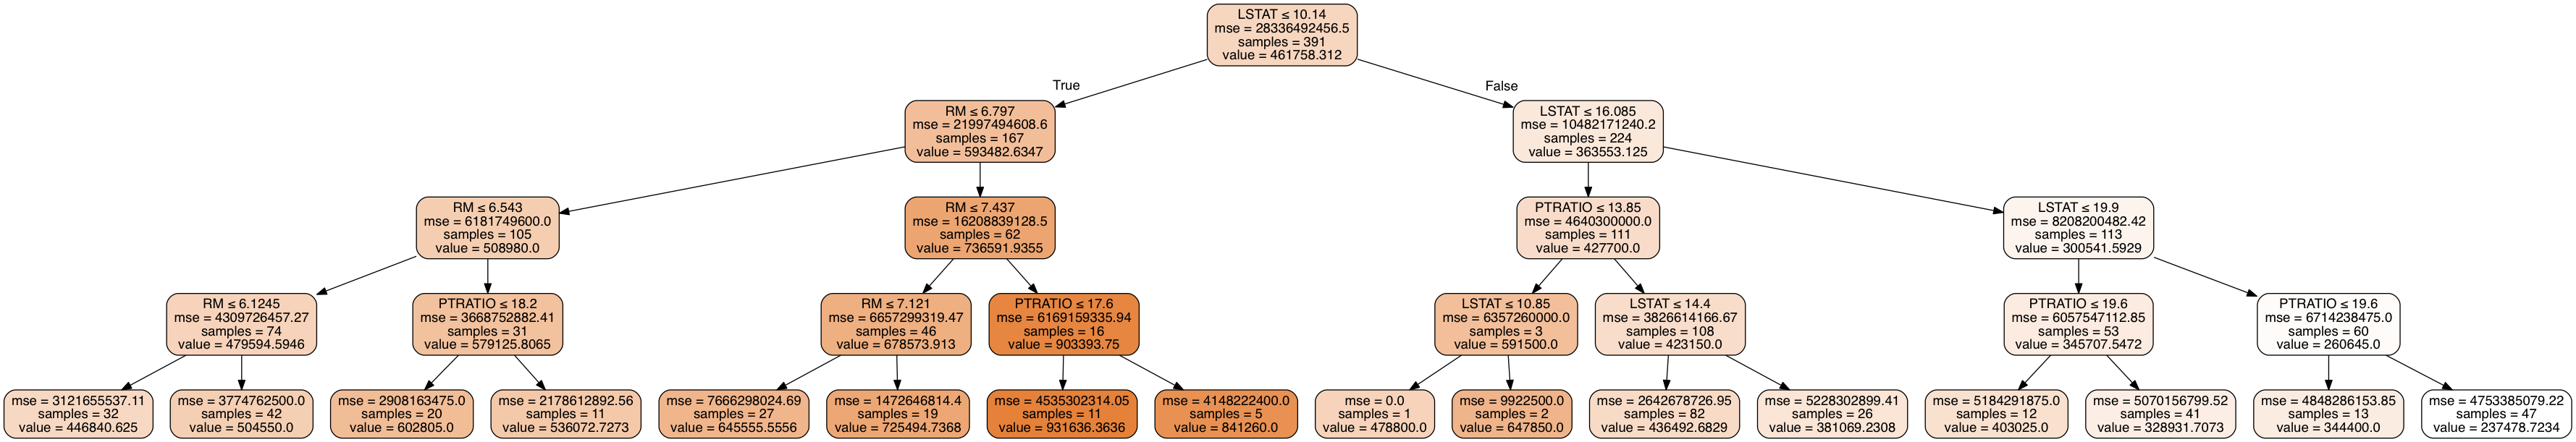

In [60]:
from IPython.display import Image, display
from sklearn.externals.six import StringIO
import pydotplus as pydot
from sklearn import tree

clf = DecisionTreeRegressor(max_depth=4)
clf = clf.fit(X_train, y_train)
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,
    feature_names=X_train.columns,
    class_names="PRICES",
    filled=True, rounded=True,
    special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())